In [88]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import paramnormal
# import seaborn as sns
# from statsmodels import api
from scipy import stats
from scipy.optimize import minimize 
import json
# import pprint


In [89]:
# This function cleans the data and creates c_0, c_f, and log_c_f

def cleanData(df):
    # Remove unnecessary columns
    df = df.drop('Link', axis=1)
    df = df.dropna()
    #df = df[df['Cited by'] >= 0]
    c_0_list = []

    # Calc c_0
    c_0 = {year : df.loc[df['Year'] == year, 'Cited by'].median() for year in range(2001,2020)}


    for index, row in df.iterrows():
        c_0_list.append(c_0[row['Year']])
        #df['c_0'][index] = c_0[row['Year']]
    df['c_0'] = c_0_list
    # Calc c_f
    # df["c_0"] = df["Cited by"].median()
    df['c_f'] = df['Cited by'] / df['c_0']
    df['c_f'].astype(np.float64)
    
    df['log_c_f'] = np.log(df['c_f'])
    
    lower = .1
    upper  = 10
    df = df[df['c_f'] >= lower]
    df = df[df['c_f'] <= upper]

    return df


In [90]:
# Load data sets

ai_ml = pd.read_csv('AI_ML.csv')
col_sys = pd.read_csv('Swarming_MultiAgent.csv')
com_net = pd.read_csv('Communications_Networking.csv')
cont_alg = pd.read_csv('ControlSystems_Algorithms.csv')
cyb_sec = pd.read_csv('CyberSecurity.csv')
edg_com = pd.read_csv('EdgeComputing.csv')
ene_mgm = pd.read_csv('EnergyManagement.csv')
eth_reg = pd.read_csv('EthicsRegulations.csv')
hum_man = pd.read_csv('HumanMachineInteraction.csv')
loc_map = pd.read_csv('Localization_mapping.csv')
sen_fus = pd.read_csv('sensor_fusion.csv')
sen_tec = pd.read_csv('sensor_technology.csv')
sim_mod = pd.read_csv('Simulation_Modeling.csv')
tec_mob = pd.read_csv('Robotics.csv')


dataSets = [ai_ml, col_sys, com_net, cont_alg, cyb_sec, edg_com, ene_mgm, eth_reg, hum_man, loc_map, sen_fus, sen_tec, sim_mod, tec_mob]
keyNames = ["ai_ml", "col_sys", "com_net", "cont_alg", "cyb_sec", "edg_com", "ene_mgm", "eth_reg", "hum_man", "loc_map", "sen_fus", "sen_tec", "sim_mod", "tec_mob"]
fullNames = ["AI & Machine Learning", "Collaborative systems", "Communications & Networking", "Control systems & Algorithms", "Cybersecurity", "Edge Computing", "Energy Management", "Ethics & Regulations", "Human Machine Interaction", "Localization & Mapping", "Sensor Fusion", "Sensor Technologies", "Simulation & Modeling", "Technologies enabling mobility"]


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


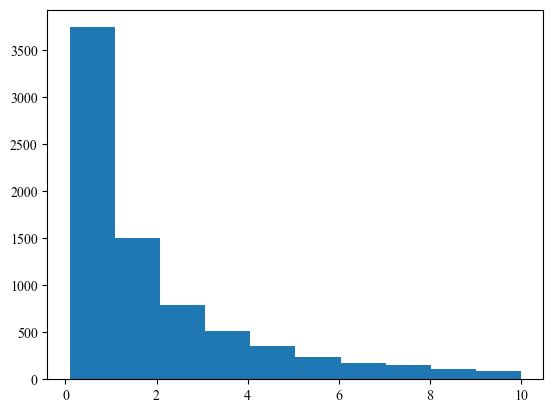

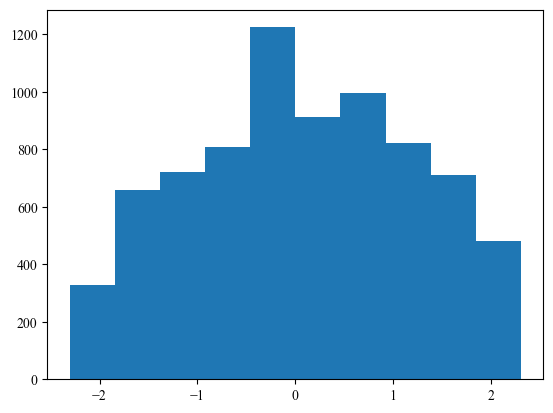

In [91]:
n = 0
name = fullNames[n]

df = cleanData(dataSets[n])
# print(df.head())
plt.hist(df.c_f)#, title=name)
plt.show()
plt.hist(df.log_c_f)#, title = name)
plt.show()

In [92]:
def MLE(dataSets):    
    dist = stats.norm
    bounds = {
        'loc': (0,1),
        # 's': (0,2),
        'scale': (0,2)
    }
    #bounds = [(0,2), (0,1), (0,5)]
    parameterDict = {}
    bins = 50

    for index, df in enumerate(dataSets):
        df = cleanData(df)
        vals = df['log_c_f'].values.tolist()
        #res = paramnormal.lognormal.fit(vals)
        res = stats.fit(dist, vals, bounds=bounds, method='mle')
        
        # print(res)
        
        parameterDict.update({keyNames[index]: {'mu': res.params.loc}})
        # parameterDict[keyNames[index]].update({'sigma': res.params.s})
        parameterDict[keyNames[index]].update({'scale': res.params.scale})
        
    return parameterDict

In [93]:
# Perform the estimation
parameters = MLE(dataSets)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjo

In [94]:
parameters

{'ai_ml': {'mu': 0.07779231669973294, 'scale': 1.1523904220623502},
 'col_sys': {'mu': 0.09729801259795955, 'scale': 1.151391095151732},
 'com_net': {'mu': 0.1254156870174036, 'scale': 1.110171345957691},
 'cont_alg': {'mu': 0.17172044940965878, 'scale': 1.090597893539816},
 'cyb_sec': {'mu': 0.12721393731695096, 'scale': 1.1107508950466323},
 'edg_com': {'mu': 0.03711512705882669, 'scale': 1.15979109838116},
 'ene_mgm': {'mu': 0.04729139943430603, 'scale': 1.1668472510814696},
 'eth_reg': {'mu': 0.0927889591228131, 'scale': 1.1468527390954224},
 'hum_man': {'mu': 0.1828964414388499, 'scale': 1.130132628758105},
 'loc_map': {'mu': 0.025869831932956666, 'scale': 1.1630588548190055},
 'sen_fus': {'mu': 0.07705810361064094, 'scale': 1.1568562133541522},
 'sen_tec': {'mu': 0.18551936857063184, 'scale': 1.1116010891523274},
 'sim_mod': {'mu': 0.19543357352495072, 'scale': 1.1346497143941703},
 'tec_mob': {'mu': 0.15474854470447935, 'scale': 1.1273357487719493}}

In [95]:
with open("distribution_params.json", "w") as write_file:
    json.dump(parameters, write_file, indent=4)

In [96]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times new roman"]

In [99]:
def chi_test(dataSets):

    res_dict = {}

    for index, df in enumerate(dataSets):
        mu = parameters[keyNames[index]]["mu"]
        # sigma = parameters[keyNames[index]]["sigma"]
        scale = parameters[keyNames[index]]["scale"]
        bin_edges = np.logspace(-1,2,20)
        df = cleanData(df)
        vals = df['c_f'].values.tolist()
        hist = plt.hist(vals, density=True, bins=bin_edges)

        dist = stats.norm(loc=mu, scale=scale)
        hist = plt.hist(vals, bins=bin_edges, density=True)
        x = bin_edges
        p = dist.pdf(x[1:len(x)])
        observed = np.array(hist[0])
        expected = np.array(p)

        epsilon = 1e-20
        df = 1

        if len(observed) == len(expected):
            chi_squared_stat = (((observed - expected)**2) / (expected + epsilon)).sum()
            crit = stats.chi2.ppf(q=0.95, df=df)
            pvalue = 1 - stats.chi2.cdf(x = chi_squared_stat, df = df)

            res_dict.update({keyNames[index]: {'chi_stat': chi_squared_stat, 'crit_value': crit, 'pvalue': pvalue}})
        else:
            print("obs and exp is not the same length", len(observed), len(expected))

        
    return res_dict
    

c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjo

,chi_stat,crit_value,pvalue
ai_ml,6.569001e+15,3.84,0.0
col_sys,8.028803e+15,3.84,0.0
com_net,8.701634e+15,3.84,0.0
cont_alg,8.935571e+15,3.84,0.0
cyb_sec,6.863321e+15,3.84,0.0
edg_com,4.140911e+15,3.84,0.0
ene_mgm,4.269934e+15,3.84,0.0
eth_reg,4.476495e+15,3.84,0.0
hum_man,8.019792e+15,3.84,0.0
loc_map,5.974096e+15,3.84,0.0


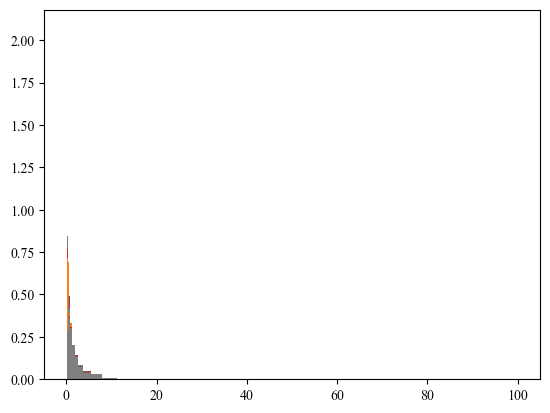

In [100]:
chi_results = chi_test(dataSets)
chi_df = pd.DataFrame(chi_results).T.round(2)
chi_df



In [ ]:
def plot_hist2(dataSets, parameters=parameters, keyNames=keyNames):
    dist = stats.lognorm
    bounds = {
        'loc': (0,1),
        's': (0,2),
        'scale': (0,2)
    }

    bin_edges = np.logspace(-1,2,20)

    fig, axs = plt.subplots(5, 3, figsize=(10,12))
    axs = axs.ravel()

    for index, df in enumerate(dataSets):
        df = cleanData(df)
        vals = df['c_f'].values.tolist()
        
        axs[index].hist(vals, bins=bin_edges, density=True, color='dimgray')
        
        mu = parameters[keyNames[index]]['mu']
        sigma = parameters[keyNames[index]]['sigma'] 
        scale = parameters[keyNames[index]]['scale'] 

        dist = stats.lognorm(loc=mu, s = sigma, scale=scale)
        p = dist.pdf(np.logspace(-0.95,2,20))
       
        axs[index].plot(bin_edges, p, color='gold')
        axs[index].set_xscale('log')
        axs[index].set_yscale('log')
        axs[index].set_title(fullNames[index])
        axs[index].set_xlabel("$c_f$", math_fontfamily='cm')

        # only set ylabel for subplots on the left
        if index % 3 == 0:
            axs[index].set_ylabel("$f$", math_fontfamily='cm')
        else:
            axs[index].set_ylabel('') # set an empty string to remove ylabel for subplots on the right

    plt.tight_layout()
    plt.savefig('researchprogress_dists_hist.pdf', format='pdf')  
    plt.show()


In [ ]:
def plot_hist2(dataSets, parameters=parameters, keyNames=keyNames):
    dist = stats.lognorm
    bounds = {
        'loc': (0,1),
        's': (0,2),
        'scale': (0,2)
    }

    bin_edges = np.logspace(-1,2,20)

    fig, axs = plt.subplots(5, 3, figsize=(9/1.25,12/1.25))
    axs = axs.ravel()

    for index, df in enumerate(dataSets):
        df = cleanData(df)
        vals = df['c_f'].values.tolist()
        
        axs[index].hist(vals, bins=bin_edges, density=True, color='dimgray')
        
        mu = parameters[keyNames[index]]['mu']
        sigma = parameters[keyNames[index]]['sigma'] 
        scale = parameters[keyNames[index]]['scale'] 

        dist = stats.lognorm(loc=mu, s = sigma, scale=scale)
        p = dist.pdf(np.logspace(-0.95,2,20))
       
        axs[index].plot(bin_edges, p, color='gold')
        axs[index].set_xscale('log')
        axs[index].set_yscale('log')
        axs[index].set_title(fullNames[index])
        axs[index].set_xlabel("$c_f$", math_fontfamily='cm')

        # only set ylabel for subplots on the left
        if index % 3 == 0:
            axs[index].set_ylabel("$f$", math_fontfamily='cm')
        else:
            axs[index].set_ylabel('') # set an empty string to remove ylabel for subplots on the right

    plt.tight_layout()
    plt.savefig('researchprogress_dists_hist.pdf', format='pdf')  
    plt.show()


In [ ]:
plot_hist2(dataSets, parameters)
plt.savefig('researchprogress_dists.pdf')  


In [ ]:


def plot_all_pdfs(dataSets, parameters=parameters, keyNames=keyNames):
    bin_edges = np.logspace(0,2,20)
    bin_edges2 = np.logspace(-0.1,2.1,20)

    fig, ax = plt.subplots()

    markers = ['o', 's', '^', 'v', '*', 'x', 'D', 'p', 'h', '+', '>', '<', 'd', '|']

    mu_list = []
    sigma_list = []
    scale_list = []

    for index, df in enumerate(dataSets):
        mu = parameters[keyNames[index]]['mu']
        sigma = parameters[keyNames[index]]['sigma']
        scale = parameters[keyNames[index]]['scale']

        mu_list.append(mu)
        sigma_list.append(sigma)
        scale_list.append(scale)

        dist = stats.lognorm(loc=mu, s=sigma, scale=scale)
        p = dist.pdf(bin_edges)

        marker = markers[index % len(markers)]
        plt.plot(bin_edges, p, marker=marker)
        plt.xscale('log')
        plt.yscale('log')

    dist = stats.lognorm(loc=np.average(mu_list), s=np.average(sigma_list), scale=np.average(scale_list))
    p = dist.pdf(bin_edges2)
    # Add a legend for the dashed line
    mu_dash = np.average(mu_list)
    sigma_dash = np.average(sigma_list)
    legend_text = f'$\mu=${mu_dash.round(2)}, \n$\sigma=${sigma_dash.round(2)}'
    #legend1 = plt.legend([legend_text], loc='upper right')
    plt.plot(bin_edges2, p, linestyle='dashed', color='black')

    ax.legend(fullNames, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig('researchprogress_dists_lines.pdf', format='pdf', bbox_inches="tight")  
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot_all_pdfs(dataSets, parameters=parameters, keyNames=keyNames):
    bin_edges = np.logspace(0,2,20)
    bin_edges2 = np.logspace(-0.1,2.1,20)

    fig, ax = plt.subplots()

    markers = ['o', 's', '^', 'v', '*', 'x', 'D', 'p', 'h', '+', '>', '<', 'd', '|']

    mu_list = []
    sigma_list = []
    scale_list = []

    for index, df in enumerate(dataSets):
        mu = parameters[keyNames[index]]['mu']
        sigma = parameters[keyNames[index]]['sigma']
        scale = parameters[keyNames[index]]['scale']

        mu_list.append(mu)
        sigma_list.append(sigma)
        scale_list.append(scale)

        dist = stats.lognorm(loc=mu, s=sigma, scale=scale)
        p = dist.pdf(bin_edges)

        marker = markers[index % len(markers)]
        plt.plot(bin_edges, p, marker=marker)
        plt.xscale('log')
        plt.yscale('log')

    dist = stats.lognorm(loc=np.average(mu_list), s=np.average(sigma_list), scale=np.average(scale_list))
    p = dist.pdf(bin_edges2)
    plt.plot(bin_edges2, p, linestyle='dashed', color='black')

    # Add a legend for the dashed line
    mu_dash = np.average(mu_list)
    sigma_dash = np.average(sigma_list)
    legend_text = f'Dashed line: \n $\mu=${mu_dash.round(2)}  \n$\sigma=${sigma_dash.round(2)}'
    ax.annotate(legend_text, xy=(0.9, 0.9), xycoords='axes fraction', ha='right', va='top', math_fontfamily='cm')
    

    ax.legend(fullNames, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.savefig('researchprogress_dists_lines.pdf', format='pdf', bbox_inches="tight")  
    plt.show()


In [ ]:
plot_all_pdfs(dataSets, parameters)

In [101]:
def test_fit_ks(dataSets, parameters=parameters, keyNames=keyNames):
    bin_edges = np.logspace(0,3,20)
    res_dict = {}
    for index, df in enumerate(dataSets):
        df = cleanData(df)
        vals = df['c_f'].values.tolist()

        mu = parameters[keyNames[index]]["mu"]
        sigma = parameters[keyNames[index]]["sigma"]
        scale = parameters[keyNames[index]]["scale"]
        dist = stats.lognorm(loc=mu, s = sigma, scale=scale)
        hist = plt.hist(vals, bins=bin_edges, density=True)
        x = bin_edges
        p = dist.pdf(x)
        obs = np.array(hist[0])
        exp = np.array(p)

        print(len(obs), len(exp))
        
        # Kolmogorov-Smirnov test
        res = stats.ks_2samp(obs, exp)
        #res = stats.ks_1samp(obs, stats.lognorm.cdf(np.logspace(-1,2,20), s=sigma))

        res_dict.update({keyNames[index]: {'pvalue': res[1]}})
        res_dict[keyNames[index]].update({'statistic': res[0]})

        print(res)
    
    return res_dict

    
        

c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)
19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\IsakG\projects\exjobb\exjobbvenv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)
19 20
KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020416, statistic_location=0.0, statistic_sign=1)


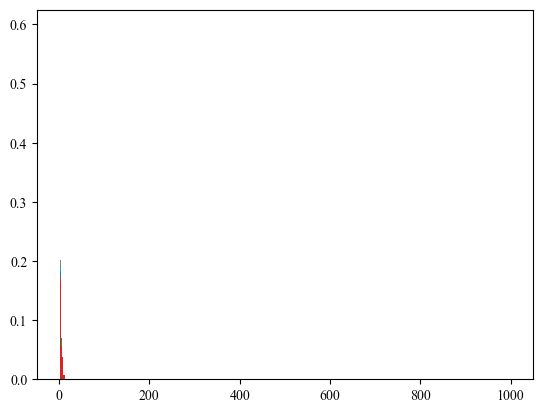

: 

In [102]:
fit_results = test_fit_ks(dataSets)


In [ ]:
c_0_list = []
c_max_list = []
c_f_max_list = []
for index, df in enumerate(dataSets):
    df = cleanData(df)
    c_0_list.append(df['Cited by'].mean())
    c_max_list.append(df['Cited by'].max())
    c_f_max_list.append(df['c_f'].max())

df = pd.DataFrame(parameters).T[['mu', 'sigma']]

df['c_0'] = c_0_list
df['c_max'] = c_max_list
df['c_f_max'] = c_f_max_list


df2 = pd.DataFrame(fit_results).T[['pvalue']]
df2 = df2.rename(columns={'pvalue': 'pvalue_ks'})
df = df.join([df2, chi_df['pvalue']])
df = df.rename(columns={'pvalue': 'pvalue_chi2'})
df = df.round(2)


df.index = fullNames
print(df)
df.to_excel('output.xlsx')

In [ ]:
ai_ml['Cited by'].max()

In [1]:
import time



while True:
    if input():
        time.sleep(1)
    else:
        print("kör")

kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
kör
